In [105]:
import pandas as pd
from nltk.translate import bleu_score
from jiwer import wer
import seaborn as sns
import numpy as np
import time, datetime

In [106]:
videos = pd.read_csv("video_list.csv")

In [107]:
# replace weird year with nan
videos['year'].loc[(videos.year > 3000)] = np.nan

/var/folders/88/g7gb2zlj44lfv2_8p54ms0880000gn/T/ipykernel_4088/745781065.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videos['year'].loc[(videos.year > 3000)] = np.nan


In [108]:
# add transcripts into the dataframe

transcripts = pd.DataFrame(columns = ['id', 'computer_transcript', 'human_transcript'])  

# will add and join human transcripts here too when we have them 

for id in videos.id:
        
    try:
        #open text file in read mode
        human_transcript_file = open("human_transcripts/%s.txt" % id, "r")
        
        #read whole file to a string
        human_transcript = human_transcript_file.read()
        
        #close file
        human_transcript_file.close()
        
        #open text file in read mode
        computer_transcript_file = open("computer_transcripts/%s.txt" % id, "r")
        
        #read whole file to a string
        computer_transcript = computer_transcript_file.read()
        
        #close file
        computer_transcript_file.close()
        
        #add row to transcripts dataframe
        transcripts.loc[len(transcripts.index)] = [id, computer_transcript, human_transcript]
        
    except IOError:
        print("%s.txt not accessible" % id )
        
        
videos = videos.merge(transcripts, on='id', how='left')
    

tobacco_qar62a00.txt not accessible
tobacco_ldo23e00.txt not accessible
tobacco_gxu03f00.txt not accessible
tobacco_gav28d00.txt not accessible
tobacco_qyq95i00.txt not accessible
tobacco_lxkv0152.txt not accessible
tobacco_byv27a00.txt not accessible
tobacco_kpp06a00.txt not accessible
tobacco_mnjp0149.txt not accessible
tobacco_kkm09c00.txt not accessible
tobacco_hxkv0152.txt not accessible
tobacco_mpp06a00.txt not accessible
tobacco_dlm09c00.txt not accessible


In [109]:
def clean_transcript(df, transcript_col):
    
    # if a comma is followed by anything other than a space, replace it with comma space
    df[transcript_col] = df[transcript_col].str.replace("(?<=[.,])(?=[^\s])"," ")
    
    # remove commas, semicolons, dashes
    df[transcript_col] = df[transcript_col].str.replace(";","")
    df[transcript_col] = df[transcript_col].str.replace(":","")
    df[transcript_col] = df[transcript_col].str.replace(",","")
    df[transcript_col] = df[transcript_col].str.replace("-","")
    
    # Remove sentence enders
    df[transcript_col] = df[transcript_col].str.replace("!","")
    df[transcript_col] = df[transcript_col].str.replace("?","")
    df[transcript_col] = df[transcript_col].str.replace("\.{2,}","")
    
    # convert all to lowercase
    df[transcript_col] = df[transcript_col].str.lower()
    
    # turn the transcript strings into lists of words 
    # split by spaces
    #df[transcript_col] = df[transcript_col].str.split(' ')

In [110]:
clean_transcript(videos, "computer_transcript")

/var/folders/88/g7gb2zlj44lfv2_8p54ms0880000gn/T/ipykernel_4088/3739907481.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df[transcript_col] = df[transcript_col].str.replace("(?<=[.,])(?=[^\s])"," ")
/var/folders/88/g7gb2zlj44lfv2_8p54ms0880000gn/T/ipykernel_4088/3739907481.py:14: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[transcript_col] = df[transcript_col].str.replace("?","")
/var/folders/88/g7gb2zlj44lfv2_8p54ms0880000gn/T/ipykernel_4088/3739907481.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  df[transcript_col] = df[transcript_col].str.replace("\.{2,}","")


In [111]:
clean_transcript(videos, "human_transcript")

/var/folders/88/g7gb2zlj44lfv2_8p54ms0880000gn/T/ipykernel_4088/3739907481.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df[transcript_col] = df[transcript_col].str.replace("(?<=[.,])(?=[^\s])"," ")
/var/folders/88/g7gb2zlj44lfv2_8p54ms0880000gn/T/ipykernel_4088/3739907481.py:14: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[transcript_col] = df[transcript_col].str.replace("?","")
/var/folders/88/g7gb2zlj44lfv2_8p54ms0880000gn/T/ipykernel_4088/3739907481.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  df[transcript_col] = df[transcript_col].str.replace("\.{2,}","")


In [112]:
# add sentiment scores
sentiment_scores = pd.read_csv("computer_human_sentiment_scores.csv")
# remove .txt from filename and rename id 
sentiment_scores.file_name = sentiment_scores['file_name'].str.replace(".txt","")
sentiment_scores = sentiment_scores.rename(columns = dict(file_name = 'id'))
sentiment_scores = sentiment_scores.drop(columns = ['file_name.1'])

# join to videos
videos = videos.merge(sentiment_scores, on='id', how='left')

/var/folders/88/g7gb2zlj44lfv2_8p54ms0880000gn/T/ipykernel_4088/4136929632.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  sentiment_scores.file_name = sentiment_scores['file_name'].str.replace(".txt","")


<AxesSubplot:xlabel='automl_confidence_avg', ylabel='year'>

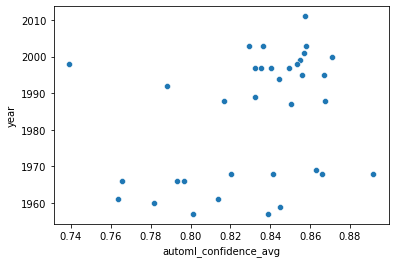

In [114]:
sns.scatterplot(x = videos['automl_confidence_avg'], y = videos['year'])

In [115]:
# calculate Word Error Rate
videos = videos.dropna(axis = 0, subset = 'human_transcript')

def calculate_wer(row):
    return wer(row['human_transcript'], row['computer_transcript'])

videos['wer'] = videos.apply(lambda row: calculate_wer(row), axis =1 )

/var/folders/88/g7gb2zlj44lfv2_8p54ms0880000gn/T/ipykernel_4088/4049123537.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videos['wer'] = videos.apply(lambda row: calculate_wer(row), axis =1 )


In [116]:
# calculate BLEU score
chencherry = bleu_score.SmoothingFunction()

def calculate_bleu(row):
    return bleu_score.sentence_bleu(row['human_transcript'].split(), row['computer_transcript'].split(), smoothing_function=chencherry.method1)

videos['bleu_score'] = videos.apply(lambda row: calculate_bleu(row), axis =1 )

/var/folders/88/g7gb2zlj44lfv2_8p54ms0880000gn/T/ipykernel_4088/682080830.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videos['bleu_score'] = videos.apply(lambda row: calculate_bleu(row), axis =1 )


In [120]:
# convert runtime column to seconds for easier correlations

videos.runtime = pd.to_timedelta(videos['runtime']).dt.total_seconds()


/var/folders/88/g7gb2zlj44lfv2_8p54ms0880000gn/T/ipykernel_4088/4091047548.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videos.runtime = pd.to_timedelta(videos['runtime']).dt.total_seconds()


In [122]:
videos.corr()

,runtime,year,automl_confidence_avg,automl_confidence_min,automl_confidence_max,computer_sentiment,computer_magnitude,human_sentiment,human_magnitude,wer,bleu_score
runtime,1.000000,0.442688,0.094118,-0.618208,0.345234,-0.329642,0.860688,-0.293020,0.553226,-0.474842,-0.323887
year,0.442688,1.000000,0.478383,-0.108663,0.335830,-0.455911,0.529469,-0.291700,-0.178796,-0.690724,-0.267553
automl_confidence_avg,0.094118,0.478383,1.000000,0.372022,0.378906,-0.414185,0.052426,-0.342371,-0.349979,-0.745298,-0.275368
automl_confidence_min,-0.618208,-0.108663,0.372022,1.000000,-0.441444,0.087679,-0.405765,0.077874,-0.804380,0.052555,0.467260
automl_confidence_max,0.345234,0.335830,0.378906,-0.441444,1.000000,-0.551604,0.276247,-0.430406,0.448252,-0.513544,-0.935678
computer_sentiment,-0.329642,-0.455911,-0.414185,0.087679,-0.551604,1.000000,-0.331573,0.665717,-0.075656,0.437212,0.408066
computer_magnitude,0.860688,0.529469,0.052426,-0.405765,0.276247,-0.331573,1.000000,-0.361601,0.410944,-0.473656,-0.267366
human_sentiment,-0.293020,-0.291700,-0.342371,0.077874,-0.430406,0.665717,-0.361601,1.000000,-0.184429,0.303641,0.395969
human_magnitude,0.553226,-0.178796,-0.349979,-0.804380,0.448252,-0.075656,0.410944,-0.184429,1.000000,0.136240,-0.455518
wer,-0.474842,-0.690724,-0.745298,0.052555,-0.513544,0.437212,-0.473656,0.303641,0.136240,1.000000,0.490309
